# North Atlantic Basin

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(15)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.689e2a7d1fb54d9d98f757f3fae5e695/status,


In [21]:
cluster.close()
client.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
import gsw
from xhistogram.xarray import histogram

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()

# 1) Spatial map of NASTMW outcropping in each month

In [5]:
mask = cesm.REGION_MASK.reset_coords(drop=True)

In [6]:
#assign each region index value to basin name

caspian_sea = -14
black_sea = -13
#unknown = -1
#unknown = 0
southern_ocean = 1
pacific_ocean = 2
indian_ocean = 3
persian_gulf = 4
red_sea = 5
atlantic_ocean = 6
med_sea = 7
lab_sea = 8
norwegian_sea = 9
arctic_ocean = 10
hudson_bay = 11
baltic_sea = 12

In [7]:
#combine natl mask w/ norwegian and labrador seas
atl_mask = (mask>=atlantic_ocean) & (mask<=norwegian_sea) & (mask!=med_sea)

In [8]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')
delta_rho = 0.1
rho_bins = np.arange(15, 35, delta_rho)

In [9]:
rho

<xarray.DataArray 'rho' (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<sigma0, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    vonkar              float64 0.0
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))


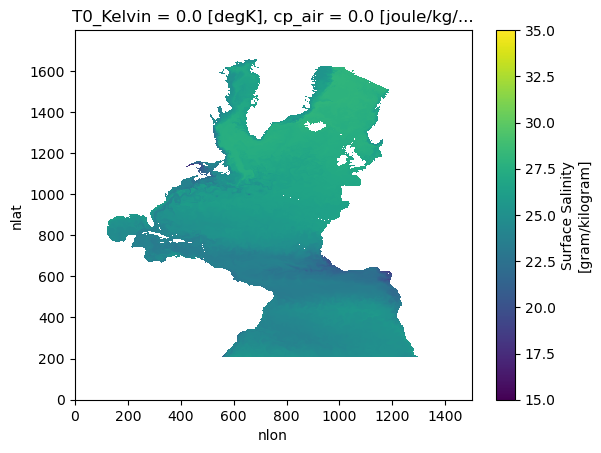

In [14]:
rho[0].where(atl_mask).isel(nlon=slice(0, 1500), nlat=slice(600, None)).plot(vmin=15, vmax=35)

In [10]:
rho_bins[115]

26.499999999999957

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sigma0
  return func(*(_execute_task(a, cache) for a in args))


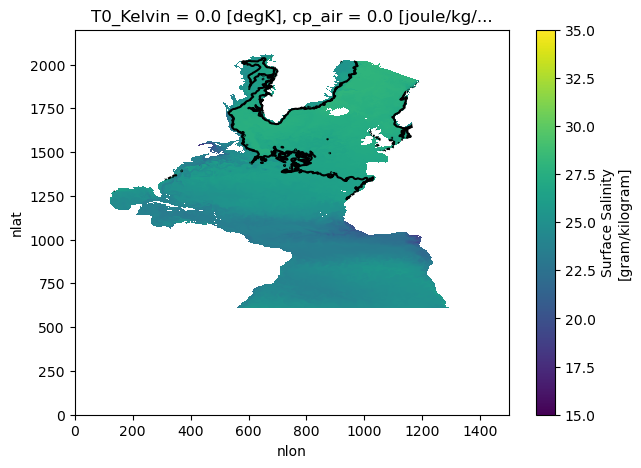

In [17]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(7,5))
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))

rho[0].where(atl_mask).isel(**selection).plot(vmin=15, vmax=35, ax=ax)
C = rho[0].where(atl_mask).isel(**selection).plot.contour(colors='k', levels=[26.499999999999957], ax=ax)#, add_colorbar=True)
#C.collections[115].set_color('k')
#C.collections[115].set_linewidth(1.5);
#plt.clabel(C);

## A) Checking isopycnal value for NASTMW via TS diagram
can't plot cross section bc no t/s vars with z dim

In [12]:
avg_mld = (cesm.HMXL_2*1e-2)#.mean('time').compute()
cm2_to_m2 = 1e-4
vol = cesm.TAREA*cm2_to_m2*avg_mld

In [13]:
salt_bins = np.linspace(15, 45, 100)
theta_bins = np.linspace(-3, 40, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

ts_hist = histogram(cesm.SST, cesm.SSS, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['nlon', 'nlat']).rename({'SST_bin':'theta_bin',
                                                              'SSS_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_SST_SSS' (time: 14965, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(14965, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
  * theta_bin  (theta_bin) float64 -2.783 -2.348 -1.914 ... 38.91 39.35 39.78
  * salt_bin   (salt_bin) float64 15.15 15.45 15.76 16.06 ... 44.24 44.55 44.85

In [14]:
ts_hist_mean = ts_hist.mean('time')

In [17]:
sigma0 = gsw.sigma0(ts_hist_mean.salt_bin, ts_hist_mean.theta_bin)
rho_mean = sigma0
sigma_levs = np.arange(18, 32, 0.5)

In [18]:
rho_mean

<xarray.DataArray 'salt_bin' (salt_bin: 99, theta_bin: 99)>
array([[11.96366136, 11.98523474, 12.00383344, ...,  4.13611115,
         3.97673105,  3.8162079 ],
       [12.20969101, 12.23079499, 12.24892904, ...,  4.35214486,
         4.19256377,  4.03184186],
       [12.45570936, 12.4763448 , 12.49401502, ...,  4.5681842 ,
         4.40840163,  4.24748042],
       ...,
       [35.57336686, 35.55261217, 35.52919278, ..., 24.92256933,
        24.74145225, 24.55919868],
       [35.81931539, 35.79814476, 35.77431157, ..., 25.13961983,
        24.95824559, 24.77573279],
       [36.06525669, 36.04367066, 36.01942418, ..., 25.35667295,
        25.17504079, 24.99226793]])
Coordinates:
  * salt_bin   (salt_bin) float64 15.15 15.45 15.76 16.06 ... 44.24 44.55 44.85
  * theta_bin  (theta_bin) float64 -2.783 -2.348 -1.914 ... 38.91 39.35 39.78
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

In [32]:
ts_hist_gb = ts_hist.groupby('time.month').mean('time')

In [33]:
ts_hist_gb

<xarray.DataArray 'histogram_SST_SSS' (month: 12, theta_bin: 99, salt_bin: 99)>
dask.array<transpose, shape=(12, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -2.783 -2.348 -1.914 ... 38.91 39.35 39.78
  * salt_bin   (salt_bin) float64 15.15 15.45 15.76 16.06 ... 44.24 44.55 44.85
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [41]:
rho_jan = gsw.sigma0(ts_hist_gb.isel(month=0).salt_bin, ts_hist_gb.isel(month=0).theta_bin)
ts_winter = ts_hist_gb.isel(month=slice(0,3)).mean('month')
rho_winter = gsw.sigma0(ts_winter.salt_bin, ts_winter.theta_bin)

In [42]:
rho_jan

<xarray.DataArray 'salt_bin' (salt_bin: 99, theta_bin: 99)>
array([[11.96366136, 11.98523474, 12.00383344, ...,  4.13611115,
         3.97673105,  3.8162079 ],
       [12.20969101, 12.23079499, 12.24892904, ...,  4.35214486,
         4.19256377,  4.03184186],
       [12.45570936, 12.4763448 , 12.49401502, ...,  4.5681842 ,
         4.40840163,  4.24748042],
       ...,
       [35.57336686, 35.55261217, 35.52919278, ..., 24.92256933,
        24.74145225, 24.55919868],
       [35.81931539, 35.79814476, 35.77431157, ..., 25.13961983,
        24.95824559, 24.77573279],
       [36.06525669, 36.04367066, 36.01942418, ..., 25.35667295,
        25.17504079, 24.99226793]])
Coordinates:
  * salt_bin   (salt_bin) float64 15.15 15.45 15.76 16.06 ... 44.24 44.55 44.85
    month      int64 1
  * theta_bin  (theta_bin) float64 -2.783 -2.348 -1.914 ... 38.91 39.35 39.78
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

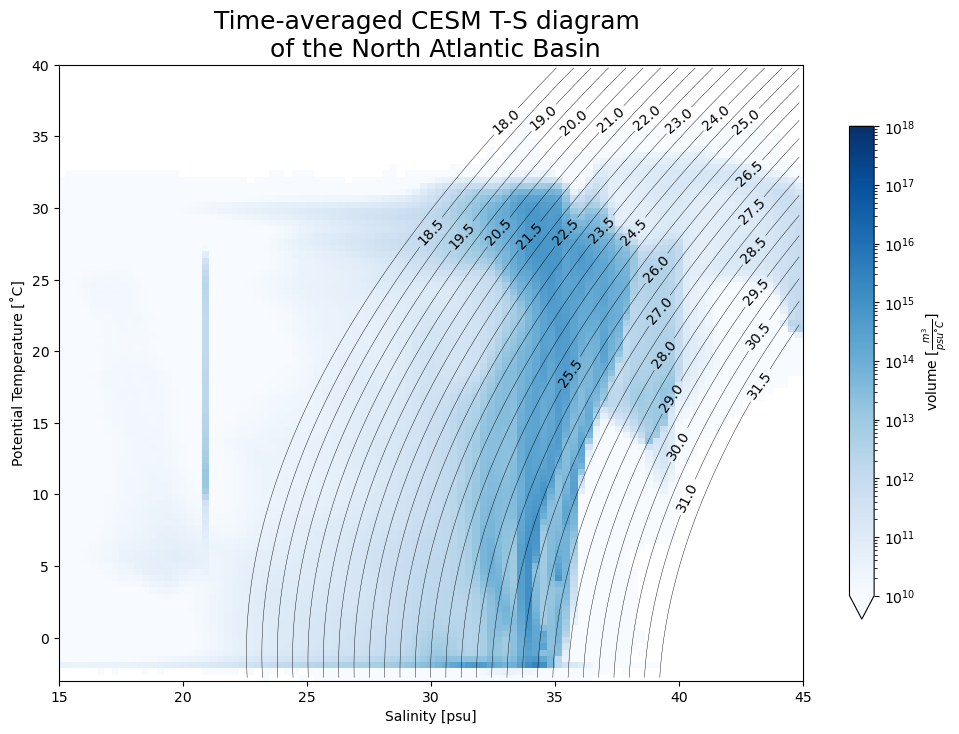

In [20]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

C = rho_mean.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
hist = ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e10, vmax=1e18, ax=ax,
                                               cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Time-averaged CESM T-S diagram \n of the North Atlantic Basin', fontsize=18)
plt.grid();

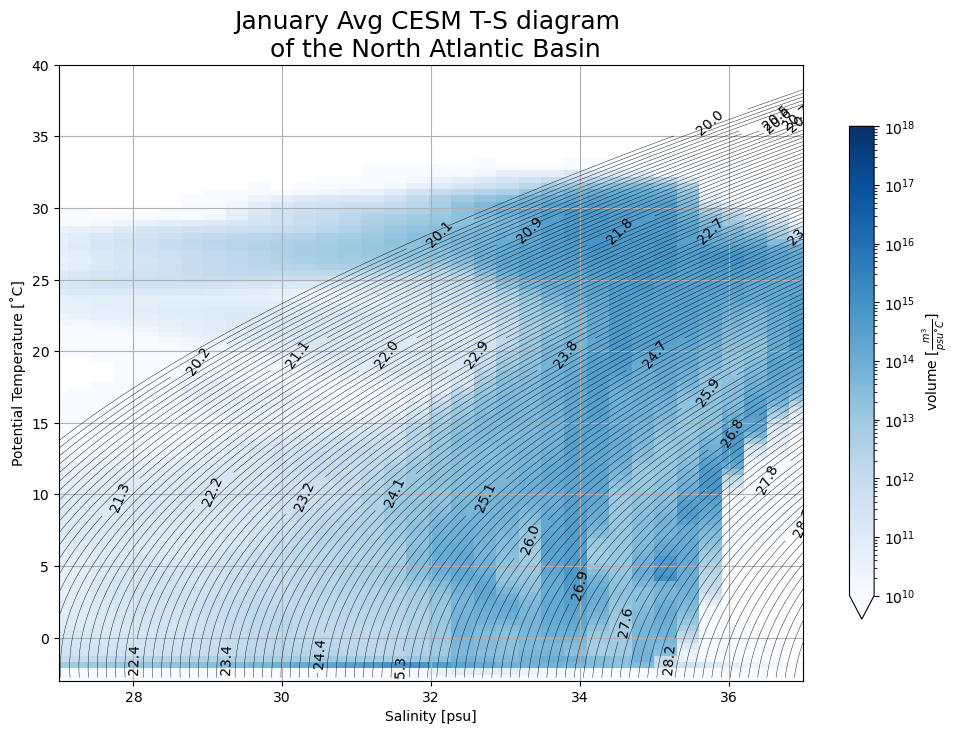

In [44]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

sigma_levs = np.arange(20, 30, 0.1)

C = rho_jan.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
hist = ts_hist_gb.isel(month=0).where(ts_hist_gb.isel(month=0)>0).plot(norm=LogNorm(), cmap='Blues', 
                                                                       vmin=1e10, vmax=1e18, ax=ax,
                                               cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('January Avg CESM T-S diagram \n of the North Atlantic Basin', fontsize=18)
ax.set_xlim(27, 37)
ax.grid();

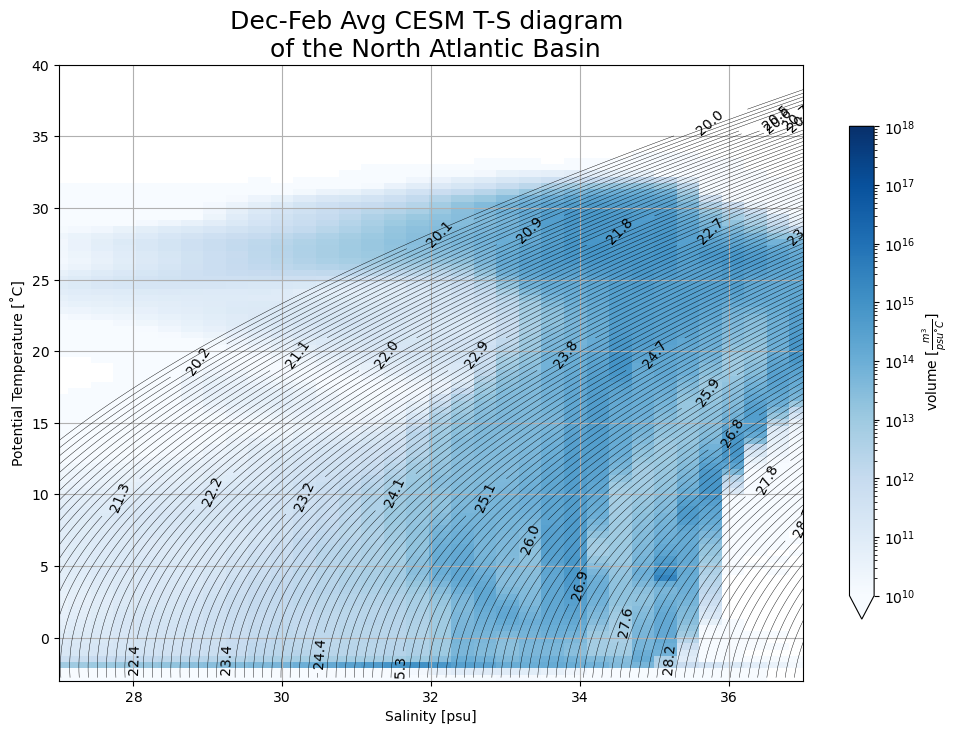

In [45]:
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

sigma_levs = np.arange(20, 30, 0.1)

C = rho_winter.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
hist = ts_winter.where(ts_winter>0).plot(norm=LogNorm(), cmap='Blues', 
                                                                       vmin=1e10, vmax=1e18, ax=ax,
                                               cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Dec-Feb Avg CESM T-S diagram \n of the North Atlantic Basin', fontsize=18)
ax.set_xlim(27, 37)
ax.grid();

## Groupby $\rho$ and plot each month's contour map

In [10]:
rho = gsw.sigma0(cesm.SSS, cesm.SST).rename('rho')

In [11]:
selection = dict(nlon=slice(0,1500), nlat=slice(200, None))
rho_gb = rho.where(atl_mask).isel(**selection).groupby('time.month').mean('time')

In [12]:
rho_gb

<xarray.DataArray 'rho' (month: 12, nlat: 2200, nlon: 1500)>
dask.array<transpose, shape=(12, 2200, 1500), dtype=float64, chunksize=(1, 2200, 1500), chunktype=numpy.ndarray>
Coordinates: (12/52)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2200, 1500), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Salinity
    units:         gram/kilogram

In [13]:
rho_bins[113]

26.29999999999996

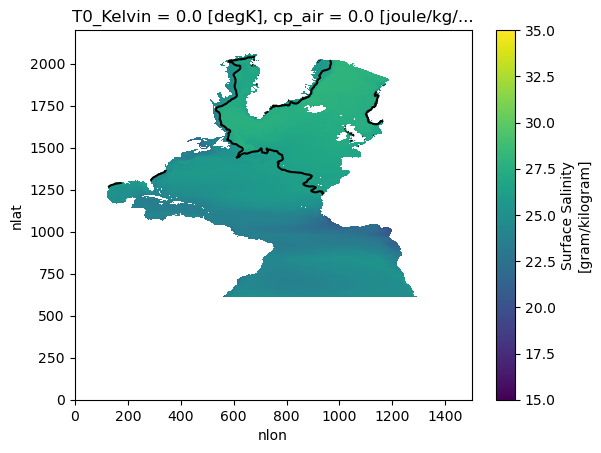

In [59]:
rho_gb[0].plot.contour(colors='k', levels=[rho_bins[113]])
rho_gb[0].plot(vmin=15, vmax=35)

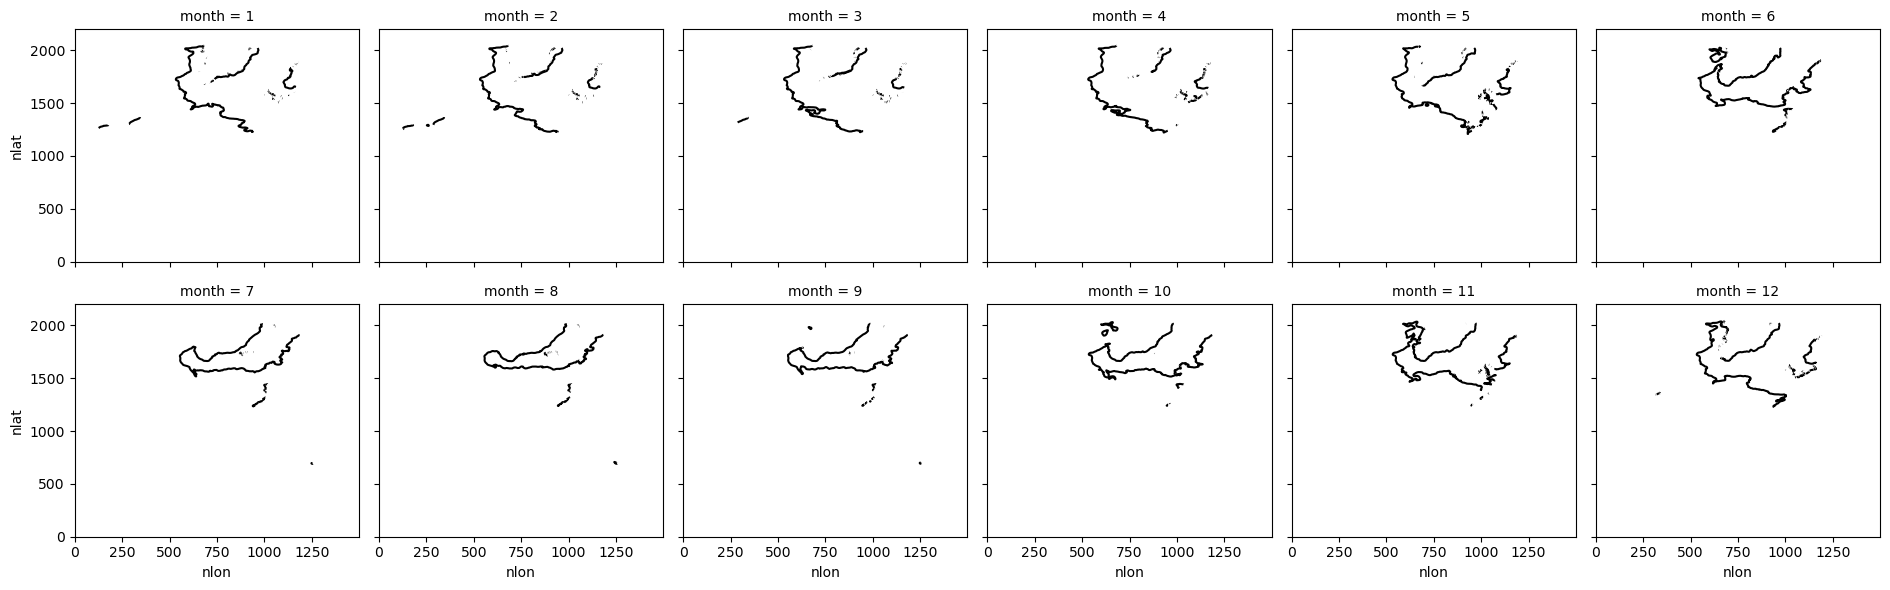

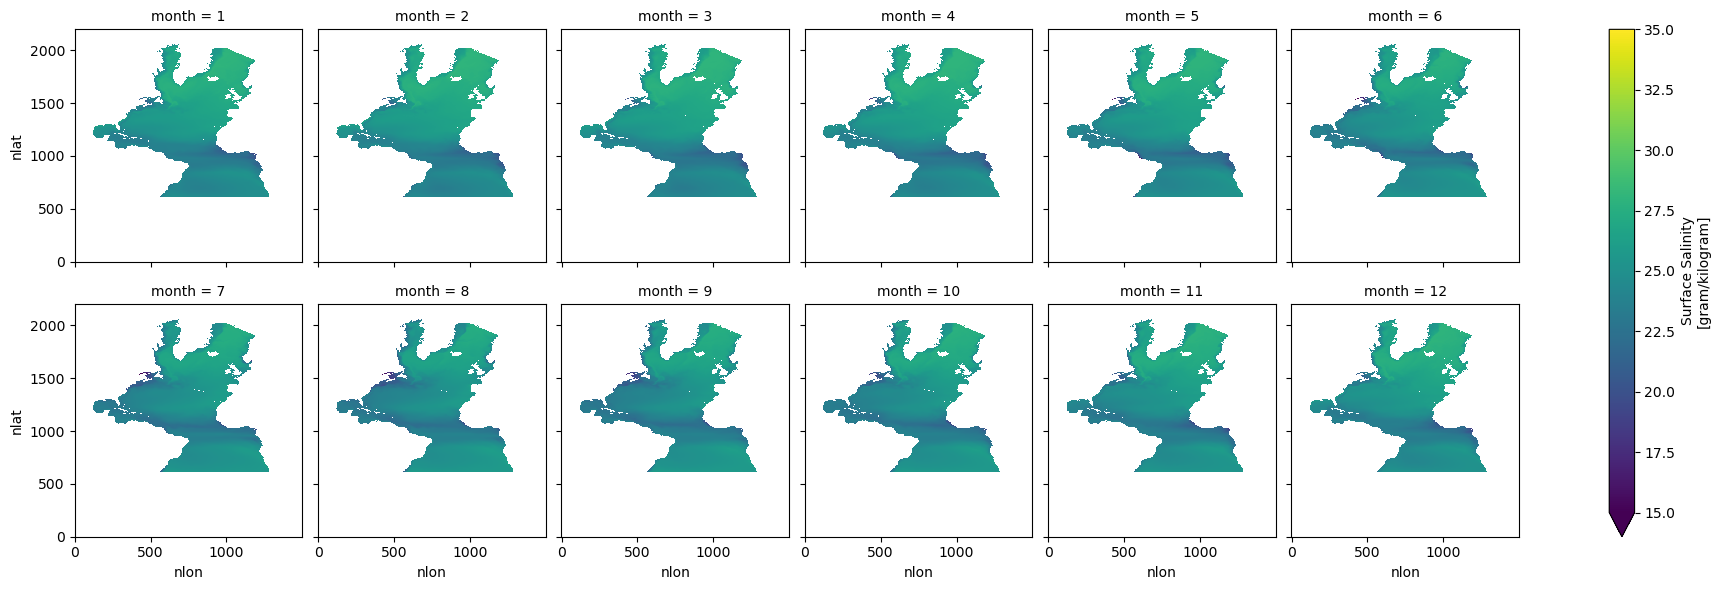

In [69]:
rho_gb.sel(month=rho_gb.month.values).plot.contour(col='month', col_wrap=6, colors='k', levels=[rho_bins[113]]);
rho_gb.sel(month=rho_gb.month.values).plot(col='month', col_wrap=6, vmin=15, vmax=35)

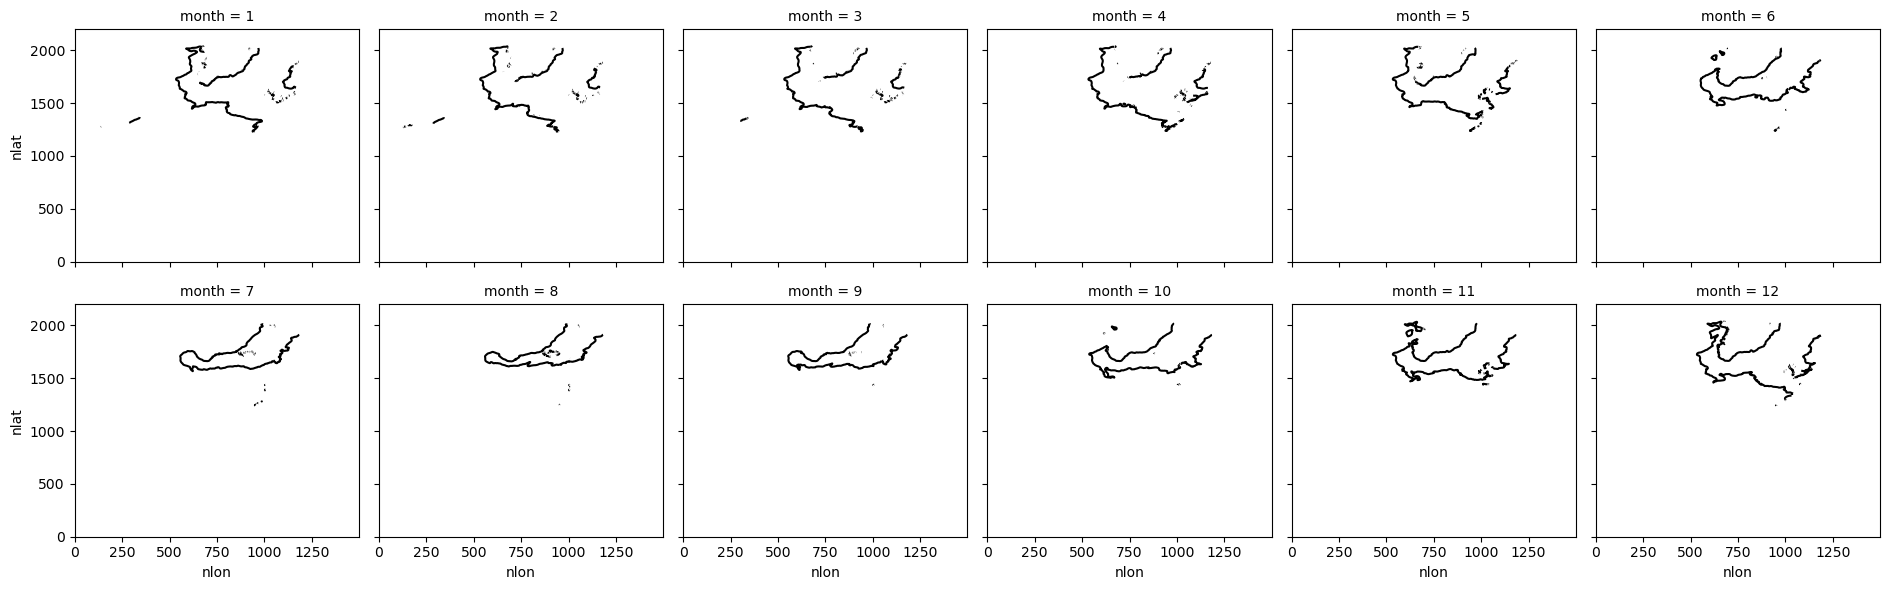

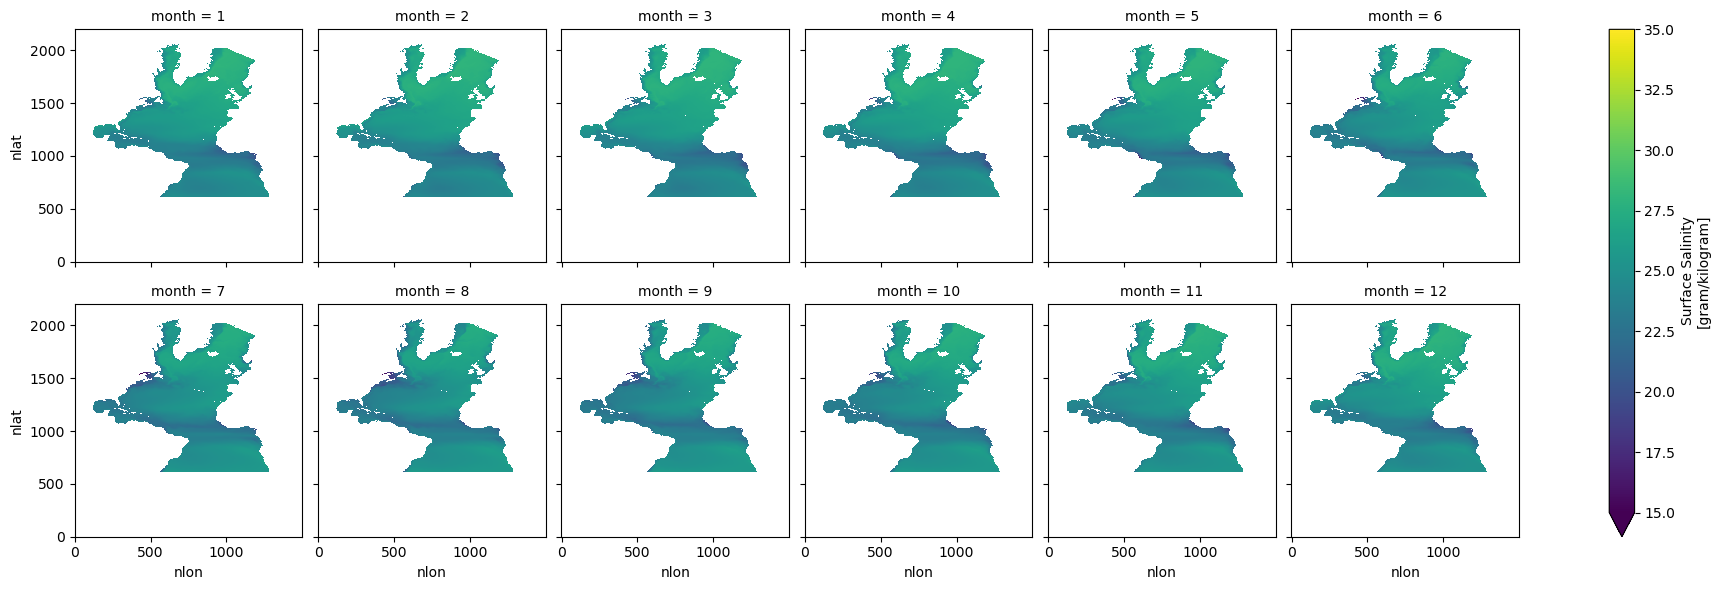

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1367, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1007)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 192, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 691, in _handle_events
    self._h

In [56]:
rho_gb.sel(month=rho_gb.month.values).plot.contour(col='month', col_wrap=6, colors='k', levels=[rho_bins[115]]);
rho_gb.sel(month=rho_gb.month.values).plot(col='month', col_wrap=6, vmin=15, vmax=35)

# Formation budget of NASTMW - monthly climatology

In [14]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(path):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/basin-histograms/'+
                                              path +'_histograms.zarr'))
    return ds
    
natl = xr.merge([open_ds('natl'), open_ds('surf_natl')])

In [15]:
nastmw = natl.sel(rho0_bin=1026.3, method='nearest')
nastmw

<xarray.Dataset>
Dimensions:               (time: 14965)
Coordinates:
    rho0_bin              float64 1.026e+03
  * time                  (time) object 0046-01-02 00:00:00 ... 0087-01-01 00...
Data variables:
    OMEGA_NATL_cabbeling  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_rho        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sss        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sst        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [16]:
nastmw_gb = nastmw.groupby('time.month').mean()

In [17]:
nastmw_gb

<xarray.Dataset>
Dimensions:               (month: 12)
Coordinates:
    rho0_bin              float64 1.026e+03
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OMEGA_NATL_cabbeling  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_rho        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sss        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_sst        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [18]:
(nastmw_gb.OMEGA_NATL_rho + nastmw_gb.OMEGA_NATL_cabbeling - nastmw_gb.OMEGA_NATL_sst - nastmw_gb.OMEGA_NATL_sss)[0].values

array(0.00184574)

In [19]:
def ann_mean(ds, basin_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_mix=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    for (i,j) in zip(list(ds.data_vars)[:-2], line_mix): #slicing to mixing terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax0)
    for (i,j) in zip(list(ds.data_vars)[-2:], line_surf): #slicing to surf terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax1)
  
    ax0.legend()
    #ax0.set_xlim(1016,1030)
    ax0.set_ylabel(r'Transformation (Sv / $\Delta \sigma_0$)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    #ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Surface terms')
    ax1.set_xlabel('')
    
    fig.supxlabel('Month', fontsize=16)
    plt.suptitle('Monthly Mean Transformation', fontsize=20)
    plt.savefig(f'{basin_title}_mo_mean_hist_fig.pdf');

In [66]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.30bd1fee51464b138f6b86a509013e9d/status,


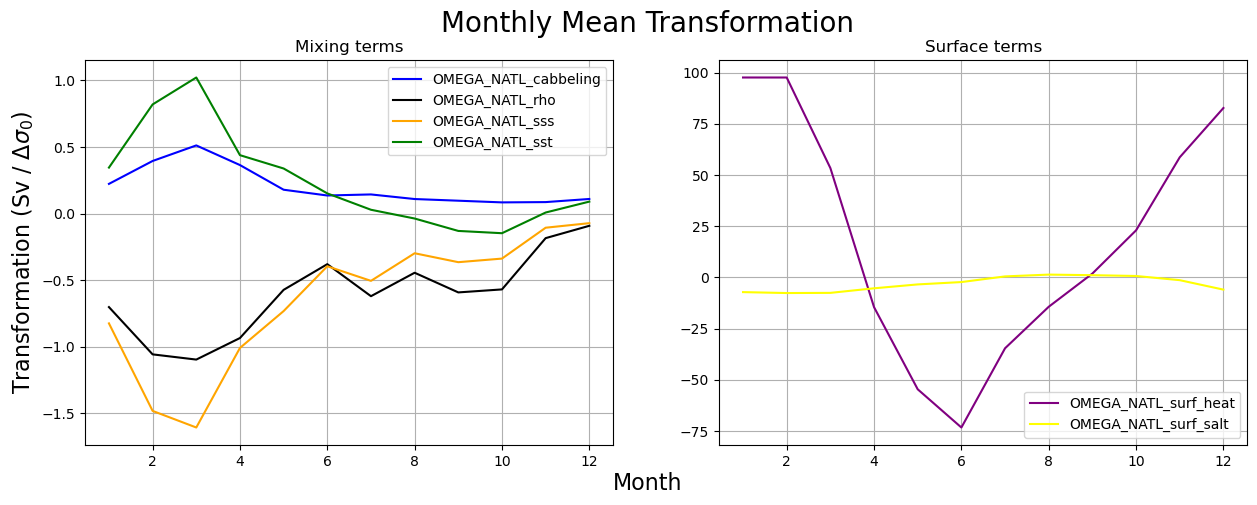

In [20]:
ann_mean(nastmw_gb, 'NATL')

# Pcolor fig

In [1]:
natl_clim = natl.groupby('time.month').mean() / 1e6

NameError: name 'natl' is not defined

In [10]:
natl_clim

<xarray.Dataset>
Dimensions:               (rho0_bin: 1499, month: 12)
Coordinates:
  * rho0_bin              (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
  * month                 (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    OMEGA_NATL_cabbeling  (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_rho        (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_sss        (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_sst        (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_surf_heat  (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_NATL_surf_salt  (month, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

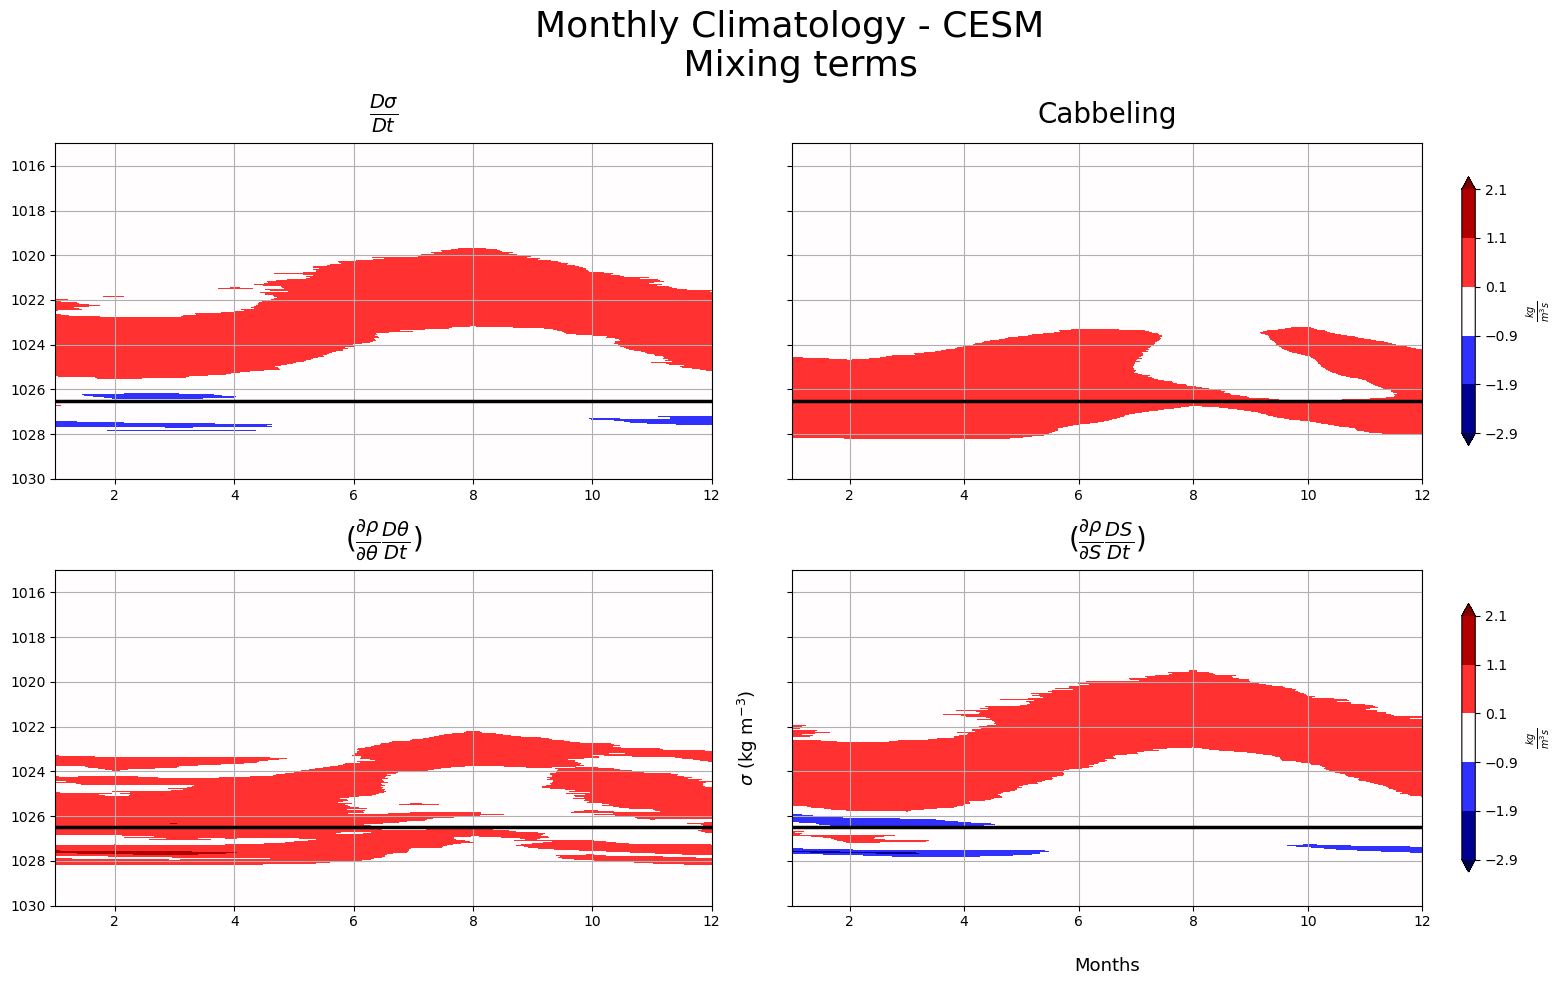

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=True, gridspec_kw={'width_ratios': [2.5,3]})

levels = np.arange(-3, 3) + 0.1

rho_clim = natl_clim.OMEGA_NATL_rho
c = ax[0,0].contourf(rho_clim.month, 
                     rho_clim.rho0_bin,
                     rho_clim.T, cmap='seismic', levels=levels, extend='both')
#ax[0,0].set_ylabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{D \sigma}{D t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1030, 1015)
ax[0,0].axhline(y=1026.5, color='k', linewidth=2.5)

cab_clim = natl_clim.OMEGA_NATL_cabbeling
c_cab = ax[0,1].contourf(cab_clim.month, cab_clim.rho0_bin, cab_clim.T,
                         cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_cab, shrink=0.8, label=r'$\frac{kg}{m^3 s}$')
ax[0,1].set_title(r'Cabbeling', fontsize=20, pad=15)
ax[0,1].grid()
ax[0,1].axhline(y=1026.5, color='k', linewidth=2.5)

sst_clim = natl_clim.OMEGA_NATL_sst
c_sst = ax[1,0].contourf(sst_clim.month, sst_clim.rho0_bin, sst_clim.T,
                           cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_sst, shrink=0.8, label='SST', ax=ax[1,0])
ax[1,0].set_title(r'$(\frac{\partial \rho}{\partial \theta} \frac{D \theta}{D t})$', fontsize=20, pad=15)
ax[1,0].grid()
ax[1,0].axhline(y=1026.5, color='k', linewidth=2.5)

sss_clim = natl_clim.OMEGA_NATL_sss
c_sss = ax[1,1].contourf(sss_clim.month, 
                                sss_clim.rho0_bin, 
                                sss_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_sss, shrink=0.8, label=r'$\frac{kg}{m^3 s}$')
ax[1,1].set_ylabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=13, labelpad=20)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$(\frac{\partial \rho}{\partial S} \frac{D S}{D t})$', fontsize=20, pad=15)
ax[1,1].grid()
ax[1,1].axhline(y=1026.5, color='k', linewidth=2.5)

plt.suptitle('Monthly Climatology - CESM \n Mixing terms', fontsize=26)
plt.tight_layout()
plt.savefig('clim-pcolor-cesm-mix.pdf', transparent=True);

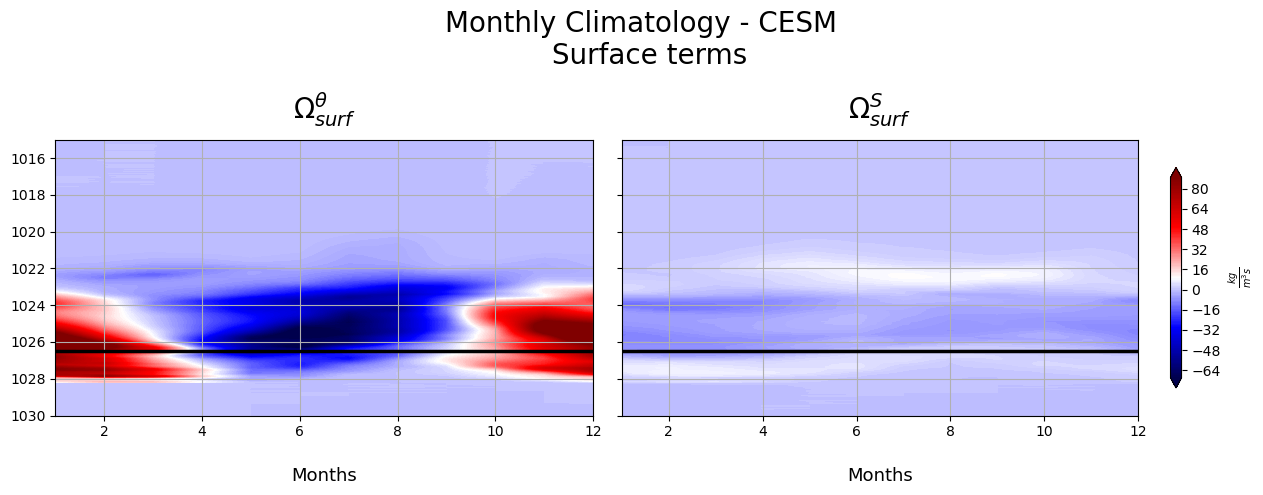

In [30]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(13, 5), sharey=True, gridspec_kw={'width_ratios': [2.5,3]})
levels = np.arange(-80, 80) + 10

surf_th_clim = natl_clim.OMEGA_NATL_surf_heat
c_surf_th = ax0.contourf(surf_th_clim.month, surf_th_clim.rho0_bin, 
                        surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
ax0.set_xlabel('Months', fontsize=13, labelpad=20)
ax0.set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax0.grid()
ax0.axhline(y=1026.5, color='k', linewidth=2.5)
ax0.set_ylim(1030, 1015)

surf_slt_clim = natl_clim.OMEGA_NATL_surf_salt
c_surf_slt = ax1.contourf(surf_slt_clim.month, surf_slt_clim.rho0_bin, 
                        surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_surf_slt, shrink=0.8, label=r'$\frac{kg}{m^3 s}$', ax=ax1)
ax1.set_xlabel('Months', fontsize=13, labelpad=20)
ax1.set_title(r'$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax1.grid()
ax1.axhline(y=1026.5, color='k', linewidth=2.5)

plt.suptitle('Monthly Climatology - CESM \n Surface terms', fontsize=20)
plt.tight_layout()
plt.savefig('clim-pcolor-cesm-surf.pdf', transparent=True);

In [70]:
client.close()
cluster.close()